<a href="https://colab.research.google.com/github/zangell44/DS-Sprint-01-Dealing-With-Data/blob/master/module4-databackedassertions/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
import random
#dir(random)  # Reminding ourselves what we can do here

In [1]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [4]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have twice as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.2 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=577.5075478052481, mobile=False), User(purchased=False, time_on_site=77.09676593379122, mobile=True), User(purchased=False, time_on_site=266.82227781635925, mobile=True), User(purchased=True, time_on_site=74.82080488795658, mobile=True), User(purchased=False, time_on_site=266.238388358925, mobile=True), User(purchased=False, time_on_site=104.32662925987091, mobile=True), User(purchased=False, time_on_site=107.02716455290164, mobile=True), User(purchased=False, time_on_site=154.04549012404757, mobile=True), User(purchased=False, time_on_site=271.7306382292984, mobile=True), User(purchased=True, time_on_site=291.4932186670609, mobile=True)]


In [5]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,577.507548,False
1,False,77.096766,True
2,False,266.822278,True
3,True,74.820805,True
4,False,266.238388,True


In [6]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.102096398107893,5.929098727049392,6.137548003863065,6.150818523389766,7.492152988695757,7.536600301597645,7.921659650968117,7.925499863052057,8.215296077656399,8.470233632561412,...,577.5075478052481,582.0434676843026,583.4197454716273,583.9490952516896,585.3652367883799,586.6257414172384,589.7266082931781,594.2973253398713,595.2258292923974,596.3764150725265
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,0,1,1,0,0,1,1,0,1,...,1,1,1,1,1,1,1,1,1,0
True,0,1,0,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [7]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.511, 123.357]","(123.357, 241.612]","(241.612, 359.867]","(359.867, 478.122]","(478.122, 596.376]"
purchased,,,,,
False,265,305,154,43,47
True,68,66,42,5,5


In [8]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.511, 123.357]","(123.357, 241.612]","(241.612, 359.867]","(359.867, 478.122]","(478.122, 596.376]"
purchased,,,,,
False,0.795796,0.822102,0.785714,0.895833,0.903846
True,0.204204,0.177898,0.214286,0.104167,0.096154


In [9]:
# That seems counter to our hypothesis
# More time on the site seems to have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.888,0.789333
True,0.112,0.210667


In [0]:
# !apt install r-base
# !pip install rpy2

# from rpy2.robjects import default_converter
# from rpy2.robjects import pandas2ri
# from rpy2.robjects.conversion import localconverter

# # use the default conversion rules to which the pandas conversion
# # is added
# with localconverter(default_converter + pandas2ri.converter) as cv:
#     dataf = robjects.r["data"]

In [0]:
#!pip install tzlocal
#!pip install rpy2



# import rpy2.robjects as robjects
# from rpy2.robjects import default_converter
# from rpy2.robjects import pandas2ri
# from rpy2.robjects.conversion import localconverter

# # use the default conversion rules to which the pandas conversion
# # is added
# with localconverter(default_converter + pandas2ri.converter) as cv:
#     df = robjects.r["data"]

In [0]:
# # Yep, mobile users are more likely to buy things
# # But we're still not seeing the *whole* story until we look at all 3 at once

# # Live/stretch goal - how can we do that?

# import seaborn as sns
# import numpy as np

# user_data_bin = user_data.copy()
# user_data_bin['time_on_site'] = pd.cut(user_data['time_on_site'], 5)

# #sns.heatmap(user_data_bin[['mobile','time_on_site']].values())

# #print (user_data_bin['time_on_site'].as_matrix())

# #np_user_data, user_data_bin['time_on_site'].values

# #print(np_user_data.size)

# print(np.asarray(user_data_bin['mobile'].as_matrix()).size)

# #sns.heatmap(np_user_data)

In [0]:
# pd.crosstab(time_bins, user_data['mobile'].groupby(user_data['purchased']),
#            normalize='columns').plot(kind = 'bar', stacked = True);

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [43]:
# load csv into data frame

import pandas as pd
import matplotlib.pyplot as plt

persons_url = 'https://raw.githubusercontent.com/LambdaSchool/DS-Sprint-01-Dealing-With-Data/master/module4-databackedassertions/persons.csv'

df_persons = pd.read_csv(persons_url, index_col=0)
df_persons.head()

,age,weight,exercise_time
0,44,118,192
1,41,161,35
2,46,128,220
3,39,216,57
4,28,116,182


In [44]:
# look at variable types
df_persons.dtypes

age              int64
weight           int64
exercise_time    int64
dtype: object

In [45]:
df_persons.describe()

,age,weight,exercise_time
count,1200.000000,1200.000000,1200.000000
mean,48.396667,153.540833,134.910833
std,18.166802,35.132182,85.548895
min,18.000000,100.000000,0.000000
25%,33.000000,125.000000,65.000000
50%,48.000000,149.000000,122.000000
75%,64.000000,180.250000,206.000000
max,80.000000,246.000000,300.000000


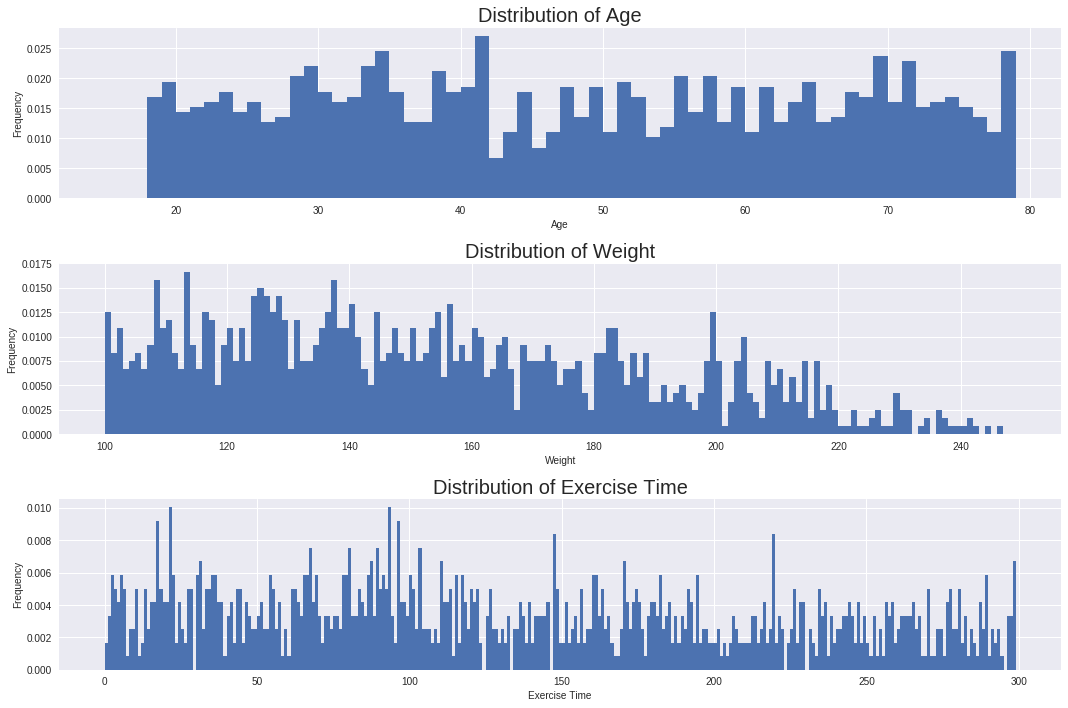

In [57]:
# plot histograms to see distribution of the underlying data

fig_hist, axes_hist = plt.subplots(3,1,figsize=(15,10))

ax_age = axes_hist[0]
ax_weight = axes_hist[1]
ax_exercise = axes_hist[2]

#age
age_freq = range(15,80)
ax_age.hist(df_persons['age'], bins=age_freq, density=True)
                 
ax_age.set_xlabel('Age', fontsize=10)
ax_age.set_ylabel('Frequency', fontsize=10)
ax_age.set_title('Distribution of Age', fontsize=20)

# weight
weight_freq = range(100,250)
ax_weight.hist(df_persons['weight'], bins=weight_freq, density=True)
                 
ax_weight.set_xlabel('Weight', fontsize=10)
ax_weight.set_ylabel('Frequency', fontsize=10)
ax_weight.set_title('Distribution of Weight', fontsize=20)

# exercise time
exercise_freq = range(0,300)
ax_exercise.hist(df_persons['exercise_time'], bins=exercise_freq, density=True)
                 
ax_exercise.set_xlabel('Exercise Time', fontsize=10)
ax_exercise.set_ylabel('Frequency', fontsize=10)
ax_exercise.set_title('Distribution of Exercise Time', fontsize=20)

plt.tight_layout()
plt.show();

In [20]:
# exploring relationships in the data
df_persons.corr()

,age,weight,exercise_time
age,1.000000,0.144168,-0.273818
weight,0.144168,1.000000,-0.478021
exercise_time,-0.273818,-0.478021,1.000000


In [0]:
# based on the above correlation matrix, we see the following
# age and weight are correlated
# age and exercise_time are inversely correlated
# exercise_time and weight are inversely correlated

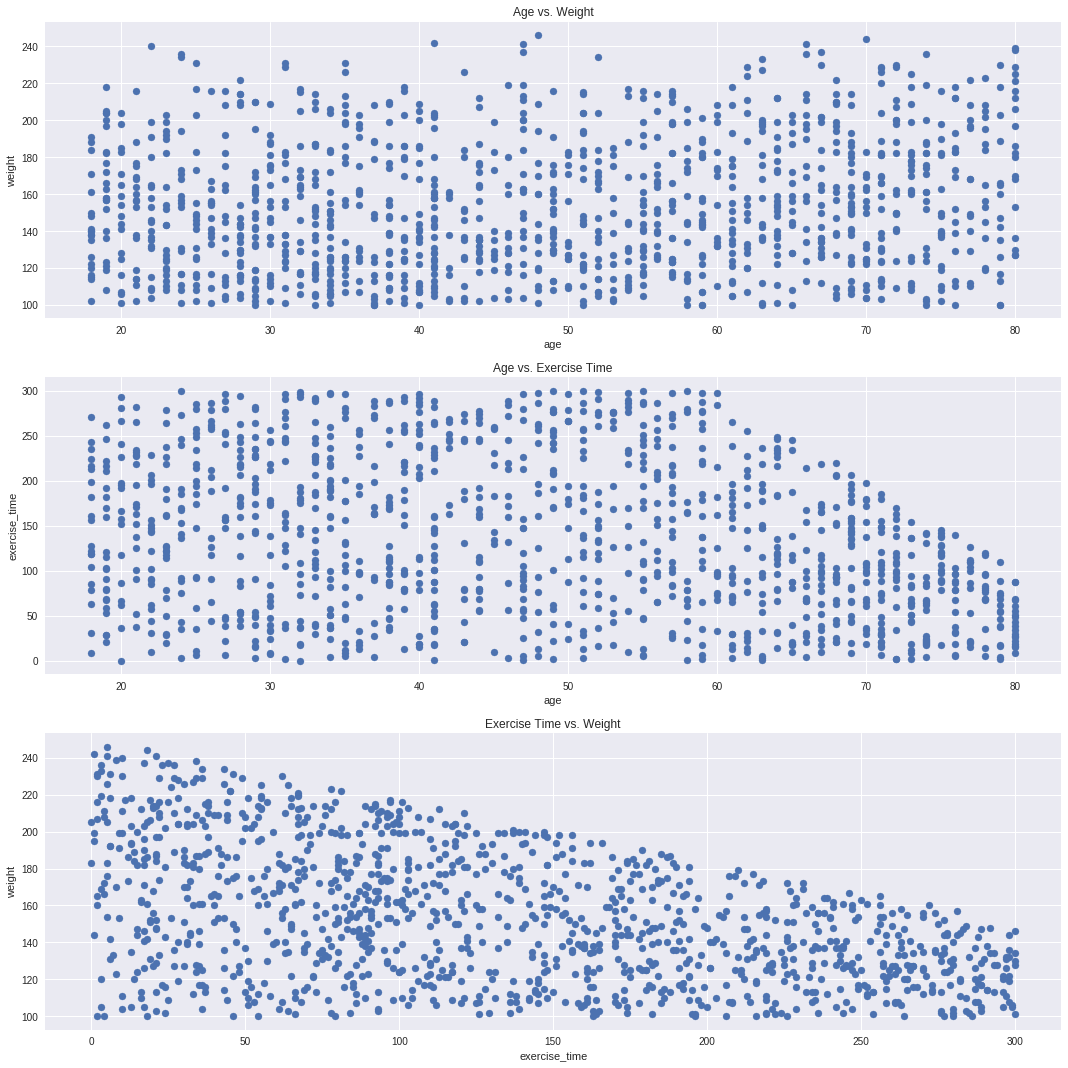

In [22]:
# correlation is only a linear measurement, so lets use some scatter plots
# to visualize

import matplotlib.pyplot as plt

fig_scatter, axes = plt.subplots(3, 1, figsize=(15,15))

# assign names to the subplots to make this easier
ax_age_weight = axes[0]
ax_age_exercise_time = axes[1]
ax_exercise_time_weight = axes[2]

ax_age_weight.scatter(df_persons['age'], df_persons['weight'])
ax_age_weight.set_xlabel('age')
ax_age_weight.set_ylabel('weight')
ax_age_weight.set_title('Age vs. Weight')

ax_age_exercise_time.scatter(df_persons['age'], df_persons['exercise_time'])
ax_age_exercise_time.set_xlabel('age')
ax_age_exercise_time.set_ylabel('exercise_time')
ax_age_exercise_time.set_title('Age vs. Exercise Time')

ax_exercise_time_weight.scatter(df_persons['exercise_time'], df_persons['weight'])
ax_exercise_time_weight.set_xlabel('exercise_time')
ax_exercise_time_weight.set_ylabel('weight')
ax_exercise_time_weight.set_title('Exercise Time vs. Weight')

plt.tight_layout()
plt.show();

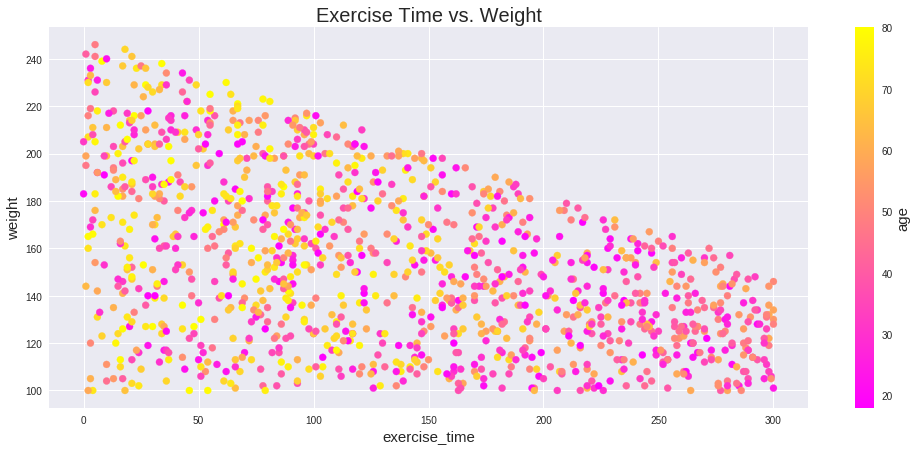

In [61]:
# there seems to be a clear inverse relationship between weight and
# exercise time. however, exercise_time also decreases as people get older
# let's see if we can vizualize age on the same scatter plot

fig_scatter_all, ax_all = plt.subplots(figsize=(17,7))

plt_all = ax_all.scatter(df_persons['exercise_time'], df_persons['weight'],
               c=df_persons['age'],
               cmap='spring')


ax_all.set_xlabel('exercise_time', fontsize=15)
ax_all.set_ylabel('weight', fontsize=15)
ax_all.set_title('Exercise Time vs. Weight', fontsize=20)

cb = plt.colorbar(plt_all)
cb.set_label('age', fontsize=15)

plt.show();

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?

All three variables, age, weight, and exercise_time are integers.

2.  What are the relationships between the variables?

As far as pure correlation goes -

*   Age is positively, but loosely, correlated with weight (note the youngest age in the sample is 18, or else this relationship would likely be stronger)
*   Exercise time is inversely correlated with weight
*   Exercise time is inversely correlated with age

Scatter plots of relationships between the three variables seem to confirm the same, although the relation is not linear. For example, exercise time sharply decreases after age 60.

3.  Which relationships are "real", and which spurious?

In this example, the dependent variable would have to be weight, which one would expect is potentially impacted by age and exercising.

We can, to some extent, control exercise time, and age is certainly not a function of the other two.

As the last (color-coded) scatter plot shows, most people who exercise less are just getting older. 

Exercising less certainly may cause people to gain weight. However, it may not be because of deliberate choice to exercise less, as aging makes exercising more difficult.

Given the data, I would argue the relationship between exercise time and weight is real. The 'spurious' relationship would be between age and weight. Aging means you may not be able to exercise as much, which would lead you to gain weight, not the mere occurence of aging.

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspierd by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)